In [1]:
#import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk
import cartopy.crs as ccrs
import time
import matplotlib as mpl
from scipy.stats import linregress
from scipy.cluster.vq import vq, kmeans2, whiten

In [2]:
from functions import *
era_land=xr.open_dataset('eralandmask_regid.nc').rename({'lat':'latitude','lon':'longitude'})

## cluster on heat trends

In [8]:
# #cmip
# cmip_slope1=xr.open_dataset('cmip_hw_tmn_doy_tmean_mktrnds_1950-2021.nc').htdays
# cmip_slope2=xr.open_dataset('cmip_newmods_hw_tmn_doy_tmean_mktrnds_1950-2021.nc').t2m
# cmip_slope=xr.concat([cmip_slope1,cmip_slope2],dim='models')
# cmip_slope.to_dataset(name='htdays').to_netcdf('cmip_25models_hw_tmn_doy_tmean_mktrnds_1950-2021.nc')


In [9]:
#read data back (hw trends)
hw_slope=xr.open_dataset('hw_tmn_doy_mktrends_smoothed_1950-2021_regrid2.nc').t2m
trend_stack=hw_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')

bk_slope=xr.open_dataset('berkley_tmn_heat_doy_mktrends_smoothed_1950-2021_regrid2.nc').t2m
bktrend_stack=bk_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')

cmip_slope=xr.open_dataset('cmip_25models_hw_tmn_doy_tmean_mktrnds_1950-2021.nc').htdays
cmiptrend_stack=cmip_slope.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')



#trend_stack=trend_stack.rename({'doys':'dayofyear'})



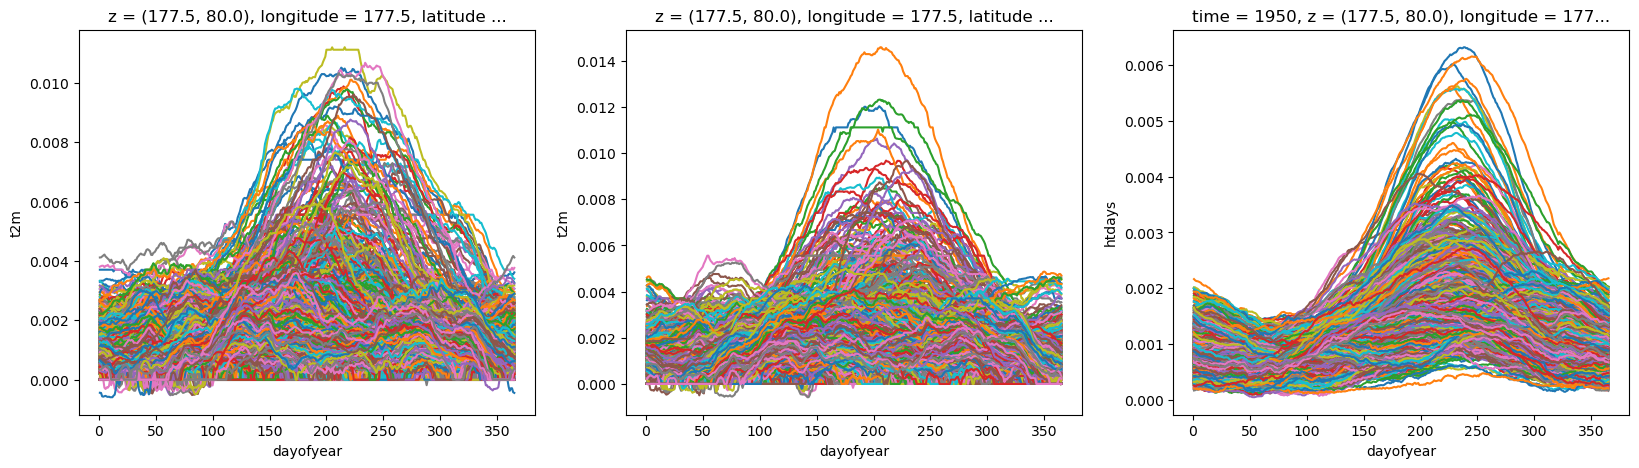

In [4]:
#plot var
cmiptrend_mmmstack=cmiptrend_stack.mean(dim='models')

fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(131)
for i in range(len(trend_stack.z)):
    trend_stack[:,i].plot(ax=ax)
ax=fig.add_subplot(132)
for i in range(len(bktrend_stack.z)):
    bktrend_stack[:,i].plot(ax=ax)
ax=fig.add_subplot(133)
for i in range(len(cmiptrend_mmmstack.z)):
    cmiptrend_mmmstack[:,i].plot(ax=ax)
plt.savefig('plots_sept/erabkcmip_mk2024.png')

In [8]:
#nmb fo grid points with pos trend
trend_posgrids=xr.where(trend_stack>0,1,0)
pvalera=xr.open_dataset('hw_tmn_doy_mkpvals_smoothed_1950-2024_regrid2.nc')
sig_gridsera=xr.where(pvalera.t2m<0.05,1,0)

bktrend_posgrids=xr.where(bktrend_stack>0,1,0)
pvalbk=xr.open_dataset('berkley_tmn_heat_doy_mkpvals_smoothed_1950-2021_regrid2.nc')
sig_gridsbk=xr.where(pvalbk.t2m<0.05,1,0)

cmiptrend_posgrids=xr.where(cmiptrend_stack>0,1,0)
#pvalcmip=xr.open_dataset('cmip_hw_tmn_doy_tmean_mkpvs_1950-2021.nc')
sig_gridscmp=xr.where(cmiptrend_posgrids.mean(dim='models')>0.8,1,0)

In [11]:
#sum sig grids
smera=sig_gridsera.sum(dim=['latitude','longitude'])
smbk=sig_gridsbk.sum(dim=['latitude','longitude'])
smcmp=sig_gridscmp.sum(dim='z')#.mean(dim='models')

#sm=sm.where(sm<1000)

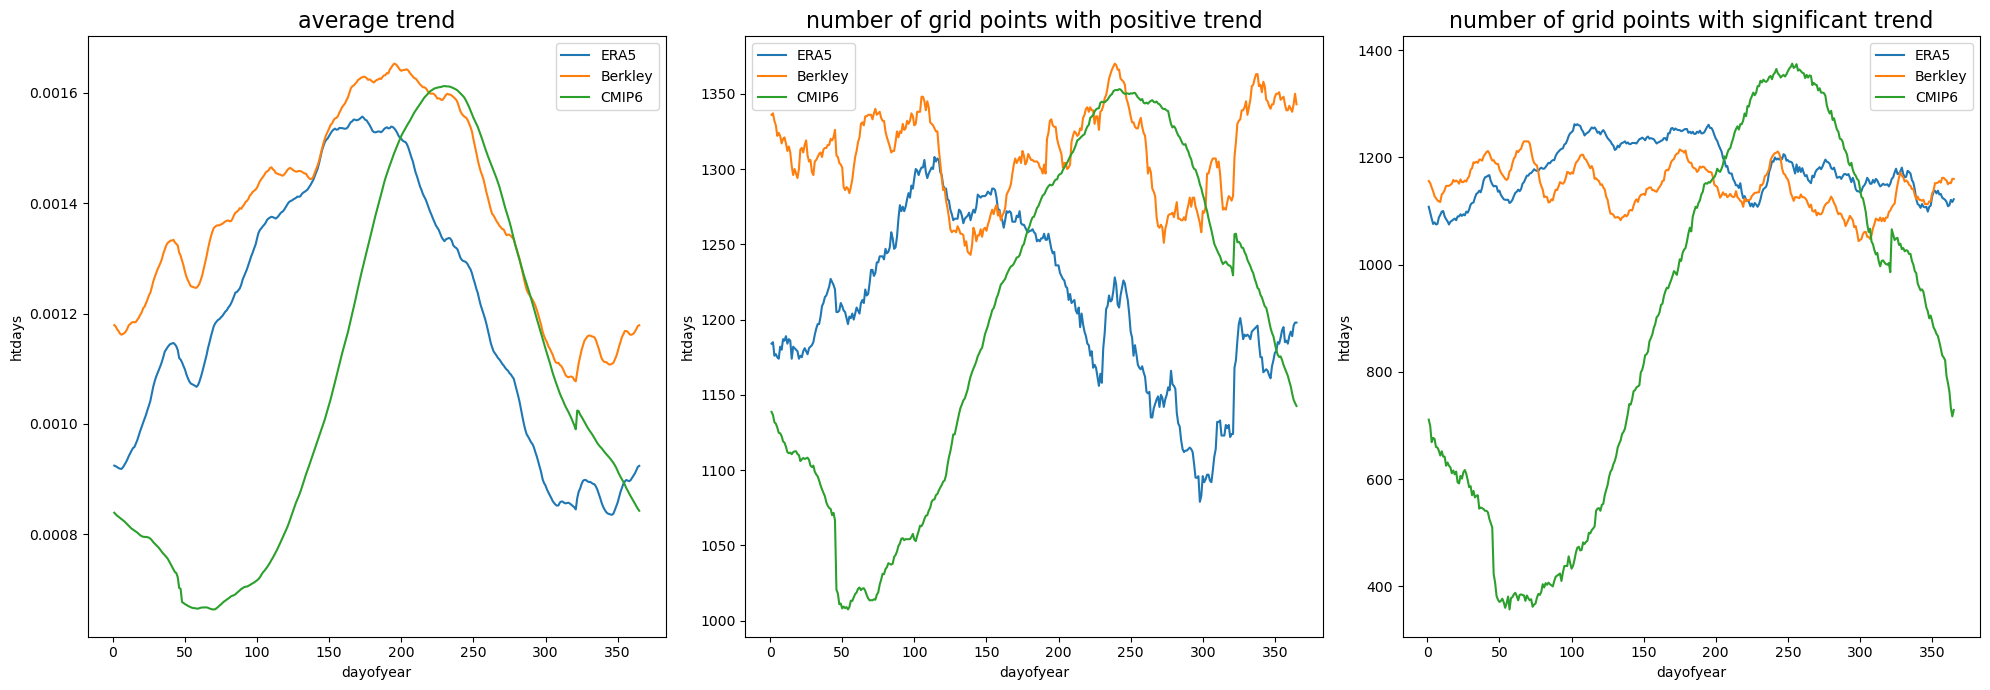

In [14]:
#plot things
fig=plt.figure(figsize=(20,7)) #add significant trends?

ax=fig.add_subplot(131)
trend_stack.mean(dim='z').plot(ax=ax, label='ERA5')
bktrend_stack.mean(dim='z').plot(ax=ax,  label='Berkley')
cmiptrend_mmmstack.mean(dim='z').plot(ax=ax,  label='CMIP6')
plt.legend()
ax.set_title('average trend', fontsize=16)
ax=fig.add_subplot(132)
trend_posgrids.sum(dim='z').plot(ax=ax, label='ERA5')
bktrend_posgrids.sum(dim='z').plot(ax=ax, label='Berkley')
cmiptrend_posgrids.sum(dim='z').mean(dim='models').plot(ax=ax, label='CMIP6')
ax.set_title('number of grid points with positive trend',fontsize=16)
plt.legend()
ax=fig.add_subplot(133)
smera.plot(ax=ax, label='ERA5')
smbk.plot(ax=ax,  label='Berkley')
smcmp.plot(ax=ax,  label='CMIP6')
plt.legend()
ax.set_title('number of grid points with significant trend', fontsize=16)

plt.tight_layout()
plt.savefig('plots_sept/trendcounts_bydoy.png')

In [11]:
#remove mean for cluster
#trend_sm_dev=trend_smoothed-trend_smoothed.mean(dim='dayofyear')
trend_sm_dev=trend_stack-trend_stack.mean(dim='dayofyear')


bktrend_sm_dev=bktrend_stack-bktrend_stack.mean(dim='dayofyear')

cmptrend_sm_dev=cmiptrend_stack-cmiptrend_stack.mean(dim='dayofyear')


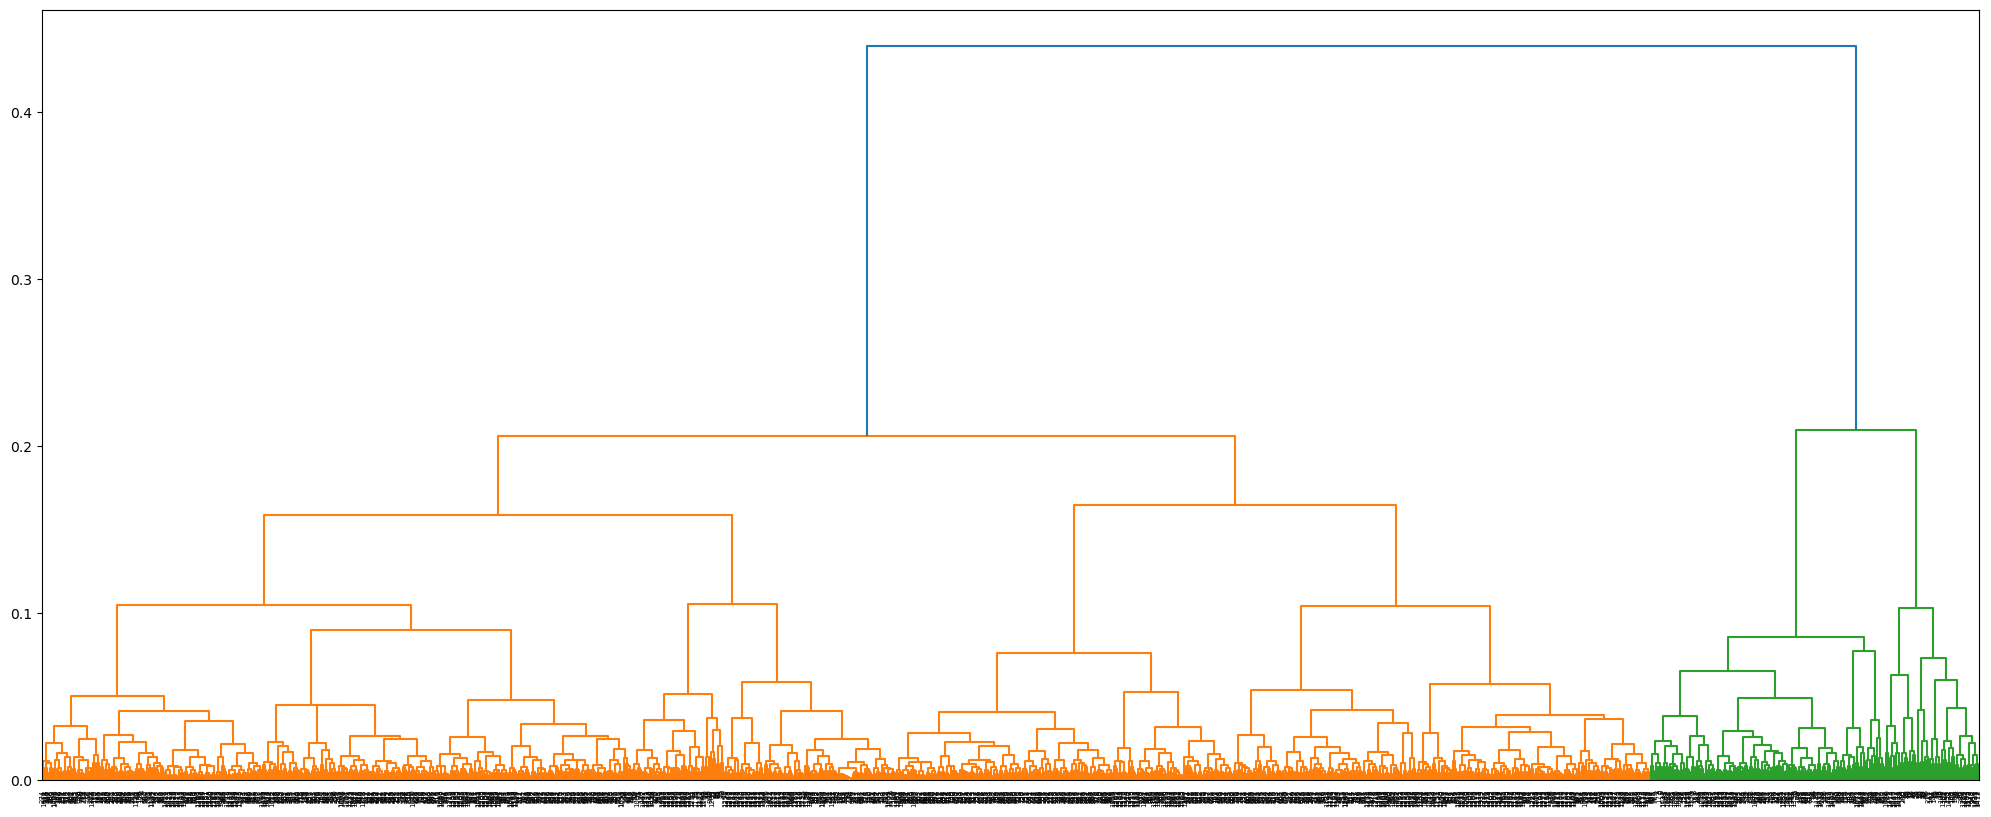

In [5]:
#Hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
trend_sm_dev_na= trend_sm_dev.dropna(dim='z')

Z = linkage(trend_sm_dev_na.T, 'ward') #
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [6]:
def kmns_glob(dat,n):
    
    data=dat.T
    num_cl=n
    rng = np.random.default_rng(seed=2)
    whitened = whiten(data)
    centroids, mean_value =kmeans(whitened,num_cl,seed=2)

    clusters, distances = vq(whitened, centroids)

    clusters_stack=xr.zeros_like(dat.isel(dayofyear=0).copy(deep=True))
    clusters_stack.values=clusters

    return clusters_stack,centroids

In [7]:
#clusters
trend_dat=trend_sm_dev.dropna(dim='z')#.to_dataset(name='t2m')

# glcluster_2,cent2=kmns_glob(trend_dat,2)
glcluster_4,cent4=kmns_glob(trend_dat,4)
#glcluster_5,cent5=kmns_glob(trend_dat,5)
#glcluster_10,cent10=kmns_glob(trend_dat,10)

In [8]:
#nan vals
def unstack_nan(dat, dat_stack, dat_stackna):

    gl_un=dat_stack.isel(dayofyear=0).copy(deep=True)
    gl_nan=dat_stackna.isel(dayofyear=0).copy(deep=True)

    gl_nan.values=dat
    gl_un.loc[gl_un.z.isin(gl_nan.z)]=gl_nan
    
    out_stack=gl_un.unstack()
    
    out_stack=out_stack.transpose('latitude', 'longitude')
    return out_stack

In [9]:
#unstack cluster mask
glcluster_4cl=unstack_nan(glcluster_4,trend_sm_dev, trend_dat)


In [10]:
clustervals=glcluster_4cl+1
ones=clustervals.where(clustervals==1).count()
twos=clustervals.where(clustervals==2).count()
thres=clustervals.where(clustervals==3).count()
fors=clustervals.where(clustervals==4).count()

print(ones,twos,thres,fors)

<xarray.DataArray 't2m' ()>
array(93)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(544)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(478)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(352)
Coordinates:
    dayofyear  int64 1


In [10]:
#glcluster_4cl.to_dataset(name='mask').to_netcdf('era5_hwcluster_mask.nc')
#glcluster_4cl=xr.open_dataset('era5_hwcluster_mask.nc').mask

In [11]:
#mask regions for temp trend

temp_slope=xr.open_dataset('tmean_doy_mktrends_1950-2024_regrid.nc')
tempss=temp_slope.t2m.copy()#clim_smoother(temp_slope.t2m.rename({'doys':'dayofyear'}),90)

tempss_4cl_1=tempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
tempss_4cl_2=tempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
tempss_4cl_3=tempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
tempss_4cl_4=tempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])


In [12]:
#era5 temp var
era_dmean=xr.open_dataset('era5/era5_tmean_daily_1950_2024_regridcon.nc').load()
era_dmean=era_dmean.sortby(era_dmean.time)
era_dmean=era_dmean.rename({'lat':'latitude','lon':'longitude'})
era_dmean=rotlon_180(era_dmean)
temp_midlat=cutmidlat(era_dmean)
temp_midlat=landmask(temp_midlat)
temp_noleap=temp_midlat.convert_calendar('noleap')
#

temp_sdrol=temp_noleap.t2m.rolling(time=10,center=True).construct('window')
temp_sdgp=temp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
temp_doysd=temp_noleap.t2m.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
temp_doygp=temp_noleap.t2m.groupby('time.dayofyear')
for i in range(len(temp_doygp)):
#     if i!=59:
    curgp=temp_sdgp[i+1].copy().assign_coords(time=temp_doysd[i].time)
    temp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=temp_doysd.doys!=60)

#temp_dvar=sd_doymn(temp_doytimes,10)

temp_doysd2=temp_doysd.mean(dim='time')
var_stack=temp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
var_st_smoothed=clim_smoother(var_stack,90)

In [13]:
#variability in clusters

#remove mean for cluster
var_sm_dev=var_st_smoothed-var_st_smoothed.mean(dim='dayofyear')

varss=var_sm_dev.unstack()

varss_4cl_1=varss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
varss_4cl_2=varss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
varss_4cl_3=varss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
varss_4cl_4=varss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [14]:
#Berk equivalent
bktemp_slope=xr.open_dataset('bk_tmean_doy_mktrends_1950-2021_regrid.nc')
bktempss=bktemp_slope.t2m.copy()#clim_smoother(bktemp_slope.t2m.rename({'doys':'dayofyear'}),90)


bktempss_4cl_1=bktempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bktempss_4cl_2=bktempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bktempss_4cl_3=bktempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bktempss_4cl_4=bktempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

bktrendss=bktrend_sm_dev.unstack()

bktrendss_4cl_1=bktrendss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bktrendss_4cl_2=bktrendss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bktrendss_4cl_3=bktrendss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bktrendss_4cl_4=bktrendss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

bk_dmean=xr.open_dataset('berkley_tmean_1950-2021_regridcon.nc').load()
bk_dmean=bk_dmean.sortby(bk_dmean.time)
bk_dmean=bk_dmean.rename({'lat':'latitude','lon':'longitude'})
bk_dmean=rotlon_180(bk_dmean)
bktemp_midlat=cutmidlat(bk_dmean)
bktemp_midlat=landmask(bktemp_midlat)
bktemp_noleap=bktemp_midlat.convert_calendar('noleap')
#

#bktemp_noleap2=bktemp_noleap.sel(time=slice('1979-01-01','2014-12-31'))
bktemp_sdrol=bktemp_noleap.temperature.rolling(time=10,center=True).construct('window')
bktemp_sdgp=bktemp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
bktemp_doysd=bktemp_noleap.temperature.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
bktemp_doygp=bktemp_noleap.temperature.groupby('time.dayofyear')
for i in range(len(bktemp_doygp)):
#     if i!=59:
    curgp=bktemp_sdgp[i+1].copy().assign_coords(time=bktemp_doysd[i].time)
    bktemp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=bktemp_doysd.doys!=60)

bktemp_doysd2=bktemp_doysd.mean(dim='time')
bkvar_stack=bktemp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
bkvar_st_smoothed=clim_smoother(bkvar_stack,90)
#smooth

bkvar_sm_dev=bkvar_st_smoothed-bkvar_st_smoothed.mean(dim='dayofyear')

#
bkvarss=bkvar_sm_dev.unstack()

bkvarss_4cl_1=bkvarss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
bkvarss_4cl_2=bkvarss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
bkvarss_4cl_3=bkvarss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
bkvarss_4cl_4=bkvarss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [15]:
#CMIP equivalent


cmptemp_slope=xr.open_dataset('cmip_tmn_doy_tmean_mktrnds_1950-2021.nc')
cmptempss=cmptemp_slope.t2m.copy()#clim_smoother(bktemp_slope.t2m.rename({'doys':'dayofyear'}),90)


cmptempss_4cl_1=cmptempss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmptempss_4cl_2=cmptempss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmptempss_4cl_3=cmptempss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmptempss_4cl_4=cmptempss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

#heat
cmptrendss=cmptrend_sm_dev.unstack()

cmptrendss_4cl_1=cmptrendss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmptrendss_4cl_2=cmptrendss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmptrendss_4cl_3=cmptrendss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmptrendss_4cl_4=cmptrendss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

cmp_dmean=xr.open_dataset('cmip6_tas_day_hist_ssp_models_regridcon.nc').load()
cmp_dmean=cmp_dmean.sortby(cmp_dmean.time)
#cmp_dmean=cmp_dmean.rename({'lat':'latitude','lon':'longitude'})
cmp_dmean=rotlon_180(cmp_dmean)
cmptemp_midlat=cutmidlat(cmp_dmean)
cmptemp_midlat=landmask(cmptemp_midlat)
cmptemp_noleap=cmptemp_midlat.convert_calendar('noleap')
#

#cmptemp_noleap2=cmptemp_noleap.sel(time=slice('1979-01-01','2014-12-31'))
cmptemp_sdrol=cmptemp_noleap.tas.rolling(time=10,center=True).construct('window')
cmptemp_sdgp=cmptemp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
cmptemp_doysd=cmptemp_noleap.tas.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
cmptemp_doygp=cmptemp_noleap.tas.groupby('time.dayofyear')
for i in range(len(cmptemp_doygp)):
#     if i!=59:
    curgp=cmptemp_sdgp[i+1].copy().assign_coords(time=cmptemp_doysd[i].time)
    cmptemp_doysd[i,]=curgp.std(dim='window')
 #.sel(doys=cmptemp_doysd.doys!=60)

cmptemp_doysd2=cmptemp_doysd.mean(dim='time')
cmpvar_stack=cmptemp_doysd2.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
cmpvar_st_smoothed=clim_smoother(cmpvar_stack,90)
#smooth

cmpvar_sm_dev=cmpvar_st_smoothed-cmpvar_st_smoothed.mean(dim='dayofyear')

#
cmpvarss=cmpvar_sm_dev.unstack()

cmpvarss_4cl_1=cmpvarss.where(glcluster_4cl==0).mean(dim=['latitude','longitude'])
cmpvarss_4cl_2=cmpvarss.where(glcluster_4cl==1).mean(dim=['latitude','longitude'])
cmpvarss_4cl_3=cmpvarss.where(glcluster_4cl==2).mean(dim=['latitude','longitude'])
cmpvarss_4cl_4=cmpvarss.where(glcluster_4cl==3).mean(dim=['latitude','longitude'])

In [16]:
#normalize

def normdat(dat):
    dat_norm = 2 * ((dat - dat.min()) / (dat.max() - dat.min())) - 1
    return dat_norm

In [17]:
def revdec_doy(dat,num=365):
    dat1=dat.copy(deep=True)
    dat1.coords['dayofyear']=xr.where(dat1['dayofyear']>334,dat1['dayofyear']-num,dat1['dayofyear'])
    dat_out=  dat1.sortby(dat1.dayofyear)
    return dat_out

In [18]:
trendss_4cl_1=xr.full_like(tempss_4cl_1,np.nan)
trendss_4cl_1.values=cent4[0]

trendss_4cl_2=xr.full_like(tempss_4cl_1,np.nan)
trendss_4cl_2.values=cent4[1]

trendss_4cl_3=xr.full_like(tempss_4cl_1,np.nan)
trendss_4cl_3.values=cent4[2]

trendss_4cl_4=xr.full_like(tempss_4cl_1,np.nan)
trendss_4cl_4.values=cent4[3]

In [19]:
clustervalsn=xr.where(clustervals==3,1,clustervals)
clustervalsn=xr.where(clustervals==2,2,clustervalsn)
clustervalsn=xr.where(clustervals==1,3,clustervalsn)
clustervalsn=xr.where(clustervals==4,4,clustervalsn)

In [20]:
ones=clustervalsn.where(clustervalsn==1).count()
twos=clustervalsn.where(clustervalsn==2).count()
thres=clustervalsn.where(clustervalsn==3).count()
fors=clustervalsn.where(clustervalsn==4).count()

print(ones,twos,thres,fors)

<xarray.DataArray 't2m' ()>
array(504)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(500)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(372)
Coordinates:
    dayofyear  int64 1 <xarray.DataArray 't2m' ()>
array(91)
Coordinates:
    dayofyear  int64 1


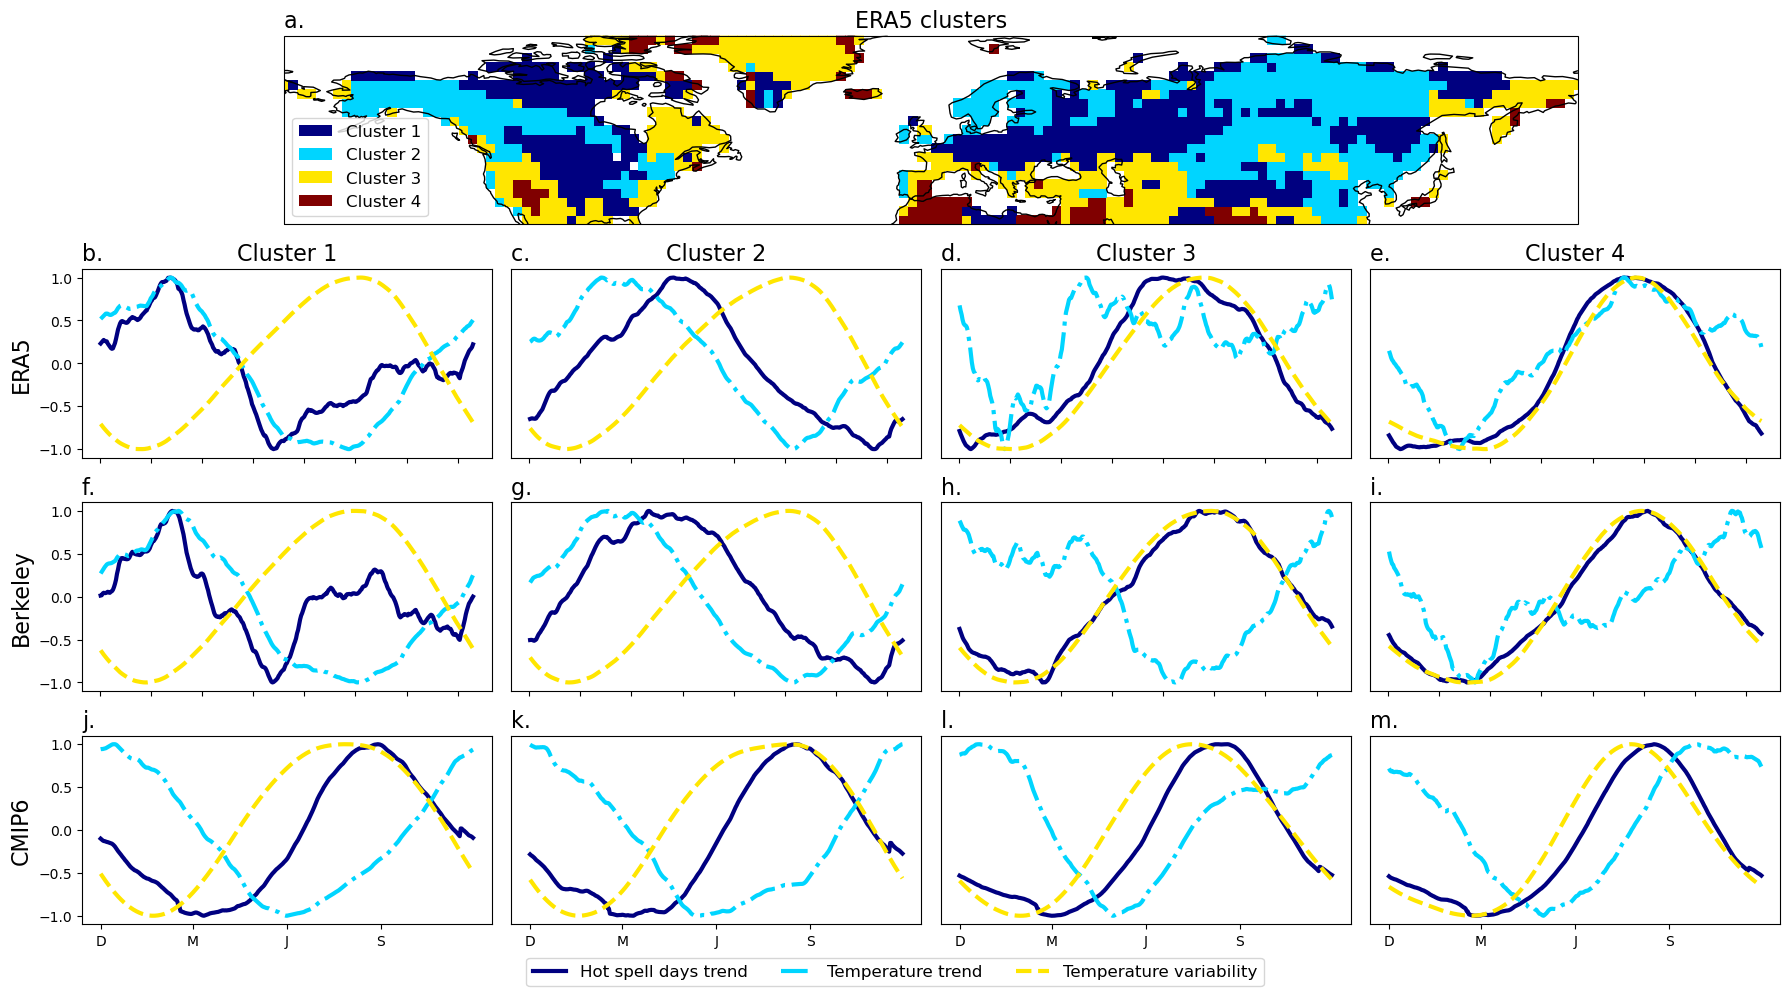

In [21]:
#plot
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import string

letters=[]
for letter in string.ascii_lowercase[0:24]:
    letters.append(letter+". ")

erahw=[trendss_4cl_1,trendss_4cl_2,trendss_4cl_3,trendss_4cl_4]
eratemp=[tempss_4cl_1,tempss_4cl_2,tempss_4cl_3,tempss_4cl_4]
eravar=[varss_4cl_1,varss_4cl_2,varss_4cl_3,varss_4cl_4]

bkhw=[bktrendss_4cl_1,bktrendss_4cl_2,bktrendss_4cl_3,bktrendss_4cl_4]
bktemp=[bktempss_4cl_1,bktempss_4cl_2,bktempss_4cl_3,bktempss_4cl_4]
bkvar=[bkvarss_4cl_1,bkvarss_4cl_2,bkvarss_4cl_3,bkvarss_4cl_4]

cmphw=[cmptrendss_4cl_1,cmptrendss_4cl_2,cmptrendss_4cl_3,cmptrendss_4cl_4]
cmptemp=[cmptempss_4cl_1,cmptempss_4cl_2,cmptempss_4cl_3,cmptempss_4cl_4]
cmpvar=[cmpvarss_4cl_1,cmpvarss_4cl_2,cmpvarss_4cl_3,cmpvarss_4cl_4]


fig=plt.figure(figsize=(18,10))

gs = fig.add_gridspec(4,4)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 4))
#plm=mpl.colormaps['plasma'].colors
#     ax=fig.add_subplot(gs[i, 0],projection=ccrs.PlateCarree())
category_colors = jet_2_colors
category_labels = ['Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4']
cmap = mcolors.ListedColormap(category_colors)

bounds = np.arange(1,6)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax=fig.add_subplot(gs[0,0:5],projection=ccrs.PlateCarree())
plot=(clustervalsn).plot(ax=ax,cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)#cbar_kwargs={'orientation':'horizontal','ticks':[1,2,3,4]})

legend_handles = [Patch(facecolor=jet_2_colors[i], label=category_labels[i]) for i in range(len(jet_2_colors))]

    # Add the legend to the plot
ax.legend(handles=legend_handles, loc='lower left',fontsize=12)
#legend.set_title('')
# plot.colorbar.set_label(label='', size=12)
# plot.colorbar.ax.set_title(label='Clusters', size=12)
# plot.colorbar.ax.tick_params(labelsize=12)
ax.set_title(letters[0],loc='left',fontsize=16)
ax.set_title('ERA5 clusters',fontsize=16)
#ax.legend()
ax.coastlines()

xticks=np.array([1,91,183,275])
xticklabels=['D','M','J','S']

order_cluster=[2,1,0,3]
for i in range(4):
    ax2=fig.add_subplot(gs[1,i])
    jet = cm.get_cmap('jet')
    jet_2_colors = jet(np.linspace(0, 1, 4))
    ax2.plot(trend_stack.dayofyear,revdec_doy(normdat(erahw[order_cluster[i]])), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(tempss_4cl_1.dayofyear,revdec_doy(normdat(eratemp[order_cluster[i]])), linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(varss_4cl_1.dayofyear,revdec_doy(-normdat(eravar[order_cluster[i]])), linewidth=3,linestyle='--',c=jet_2_colors[2],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_title(letters[i+1],loc='left',fontsize=16)
    ax2.set_title('Cluster '+str(i+1), fontsize=16)
    #ax2.set_xticks(xticks)
    ax2.set_xticklabels('')
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('ERA5', fontsize=16)

    ax2=fig.add_subplot(gs[2,i])
    jet = cm.get_cmap('jet')
    #jet_2_colors = jet(np.linspace(0, 1, 2))
    ax2.plot(bktrend_stack.dayofyear,revdec_doy(normdat(bkhw[order_cluster[i]])), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(bktempss_4cl_1.dayofyear,revdec_doy(normdat(bktemp[order_cluster[i]])), linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(bkvarss_4cl_1.dayofyear,revdec_doy(-normdat(bkvar[order_cluster[i]])), linewidth=3,linestyle='--',c=jet_2_colors[2],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_xticklabels('')
    ax2.set_title(letters[i+5],loc='left',fontsize=16)
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('Berkeley', fontsize=16)

    ax2=fig.add_subplot(gs[3,i])
    jet = cm.get_cmap('jet')
    #jet_2_colors = jet(np.linspace(0, 1, 2))
    ax2.plot(cmiptrend_stack.dayofyear,revdec_doy(normdat(cmphw[order_cluster[i]].mean(dim='models'))), linewidth=3, c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(cmptempss_4cl_1.dayofyear,revdec_doy(normdat(cmptemp[order_cluster[i]].mean(dim='models'))), linewidth=3,linestyle='-.',c=jet_2_colors[1],label='Temperature trend')
    ax2.plot(cmpvarss_4cl_1.dayofyear,revdec_doy(-normdat(cmpvar[order_cluster[i]].mean(dim='models'))), linewidth=3,linestyle='--',c=jet_2_colors[2],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_title(letters[i+9],loc='left',fontsize=16)
    if i !=0:
        ax2.set_yticks([])
    else:
        ax2.set_ylabel('CMIP6', fontsize=16)
#     if i==3:
#         plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.75), fontsize=12)

    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)
handles=[]
labels=[]
h, l = ax2.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)

fig.legend(handles, labels,ncol=3, loc='lower center', fontsize=12, bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust( bottom=0.07)
plt.savefig('plots_final/clusters_main.png')

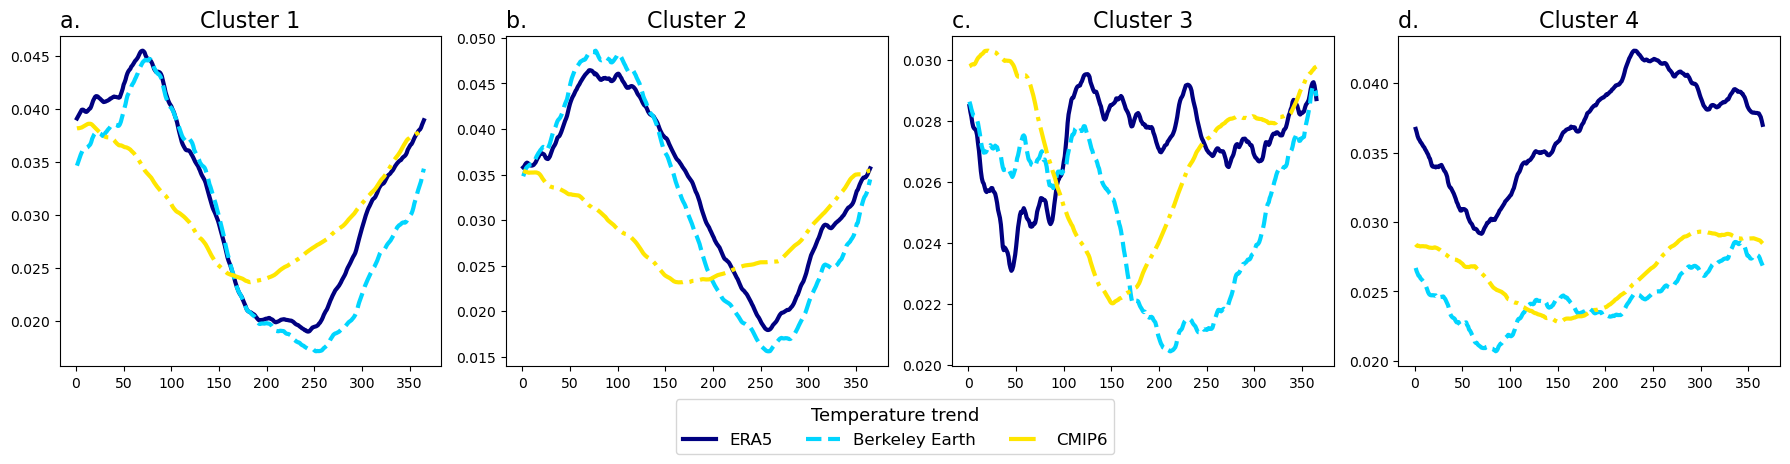

In [41]:
#plot
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import string

letters=[]
for letter in string.ascii_lowercase[0:24]:
    letters.append(letter+". ")

erahw=[trendss_4cl_1,trendss_4cl_2,trendss_4cl_3,trendss_4cl_4]
eratemp=[tempss_4cl_1,tempss_4cl_2,tempss_4cl_3,tempss_4cl_4]
eravar=[varss_4cl_1,varss_4cl_2,varss_4cl_3,varss_4cl_4]

bkhw=[bktrendss_4cl_1,bktrendss_4cl_2,bktrendss_4cl_3,bktrendss_4cl_4]
bktemp=[bktempss_4cl_1,bktempss_4cl_2,bktempss_4cl_3,bktempss_4cl_4]
bkvar=[bkvarss_4cl_1,bkvarss_4cl_2,bkvarss_4cl_3,bkvarss_4cl_4]

cmphw=[cmptrendss_4cl_1,cmptrendss_4cl_2,cmptrendss_4cl_3,cmptrendss_4cl_4]
cmptemp=[cmptempss_4cl_1,cmptempss_4cl_2,cmptempss_4cl_3,cmptempss_4cl_4]
cmpvar=[cmpvarss_4cl_1,cmpvarss_4cl_2,cmpvarss_4cl_3,cmpvarss_4cl_4]


fig=plt.figure(figsize=(18,4))

gs = fig.add_gridspec(1,4)
# jet = cm.get_cmap('jet')
# jet_2_colors = jet(np.linspace(0, 1, 4))
# #plm=mpl.colormaps['plasma'].colors
# #     ax=fig.add_subplot(gs[i, 0],projection=ccrs.PlateCarree())
# category_colors = jet_2_colors
# category_labels = ['Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4']
# cmap = mcolors.ListedColormap(category_colors)

# bounds = np.arange(1,6)
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# ax=fig.add_subplot(gs[0,0:5],projection=ccrs.PlateCarree())
# plot=(clustervalsn).plot(ax=ax,cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),add_colorbar=False)#cbar_kwargs={'orientation':'horizontal','ticks':[1,2,3,4]})

# legend_handles = [Patch(facecolor=jet_2_colors[i], label=category_labels[i]) for i in range(len(jet_2_colors))]

#     # Add the legend to the plot
# ax.legend(handles=legend_handles, loc='lower left',fontsize=12)
# #legend.set_title('')
# # plot.colorbar.set_label(label='', size=12)
# # plot.colorbar.ax.set_title(label='Clusters', size=12)
# # plot.colorbar.ax.tick_params(labelsize=12)
# ax.set_title(letters[0],loc='left',fontsize=16)
# ax.set_title('ERA5 clusters',fontsize=16)
# #ax.legend()
# ax.coastlines()

xticks=np.array([1,91,183,275])
xticklabels=['D','M','J','S']

order_cluster=[2,1,0,3]
for i in range(4):
    ax2=fig.add_subplot(gs[0,i])
    jet = cm.get_cmap('jet')
    jet_2_colors = jet(np.linspace(0, 1, 4))
    #ax2.plot(trend_stack.dayofyear,revdec_doy(erahw[order_cluster[i]]), c=jet_2_colors[0],label='Hot spell days trend')
    ax2.plot(tempss_4cl_1.dayofyear,revdec_doy(eratemp[order_cluster[i]]),c=jet_2_colors[0], linewidth=3,label='ERA5')
    ax2.plot(bktempss_4cl_1.dayofyear,revdec_doy(bktemp[order_cluster[i]]),c=jet_2_colors[1], linewidth=3,linestyle='--',label='Berkeley Earth')
    ax2.plot(cmptempss_4cl_1.dayofyear,revdec_doy(cmptemp[order_cluster[i]].mean(dim='models')), linewidth=3,linestyle='-.',c=jet_2_colors[2],label='CMIP6')
   
   
    #ax2.plot(varss_4cl_1.dayofyear,revdec_doy(-normdat(eravar[order_cluster[i]])),c=jet_2_colors[2],label='Temperature variability')
    #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
    ax2.set_title(letters[i],loc='left',fontsize=16)
    ax2.set_title('Cluster '+str(i+1), fontsize=16)
    #ax2.set_xticks(xticks)
#     ax2.set_xticklabels('')
# #     if i !=0:
# #         ax2.set_yticks([])
# #     else:
# #         ax2.set_ylabel('ERA5', fontsize=16)

#     ax2=fig.add_subplot(gs[2,i])
#     jet = cm.get_cmap('jet')
#     #jet_2_colors = jet(np.linspace(0, 1, 2))
#     #ax2.plot(bktrend_stack.dayofyear,revdec_doy(normdat(bkhw[order_cluster[i]])), c=jet_2_colors[0],label='Hot spell days trend')
#     ax2.plot(bktempss_4cl_1.dayofyear,revdec_doy(bktemp[order_cluster[i]]),c=jet_2_colors[1],label='Temperature trend')
#     #ax2.plot(bkvarss_4cl_1.dayofyear,revdec_doy(-normdat(bkvar[order_cluster[i]])),c=jet_2_colors[2],label='Temperature variability')
#     #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
#     ax2.set_xticklabels('')
#     ax2.set_title(letters[i+5],loc='left',fontsize=16)
# #     if i !=0:
# #         ax2.set_yticks([])
# #     else:
# #         ax2.set_ylabel('Berkeley', fontsize=16)

#     ax2=fig.add_subplot(gs[3,i])
#     jet = cm.get_cmap('jet')
#     #jet_2_colors = jet(np.linspace(0, 1, 2))
#     #ax2.plot(cmiptrend_stack.dayofyear,revdec_doy(normdat(cmphw[order_cluster[i]].mean(dim='models'))), c=jet_2_colors[0],label='Hot spell days trend')
#     ax2.plot(cmptempss_4cl_1.dayofyear,revdec_doy(cmptemp[order_cluster[i]].mean(dim='models')),c=jet_2_colors[1],label='Temperature trend')
#     #ax2.plot(cmpvarss_4cl_1.dayofyear,revdec_doy(-normdat(cmpvar[order_cluster[i]].mean(dim='models'))),c=jet_2_colors[2],label='Temperature variability')
#     #ax2.plot(trend_stack.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
#     ax2.set_title(letters[i+9],loc='left',fontsize=16)
# #     if i !=0:
# #         ax2.set_yticks([])
# #     else:
# #         ax2.set_ylabel('CMIP6', fontsize=16)
# #     if i==3:
# #         plt.legend(loc='lower left', bbox_to_anchor=(1.05, 0.75), fontsize=12)

#     ax2.set_xticks(xticks)
#     ax2.set_xticklabels(xticklabels)
handles=[]
labels=[]
h, l = ax2.get_legend_handles_labels()
handles.extend(h)
labels.extend(l)

fig.legend(handles, labels,ncol=3,title='Temperature trend', title_fontsize=13, loc='lower center', fontsize=12, bbox_to_anchor=(0.5, -0.17))

plt.tight_layout()
plt.subplots_adjust( bottom=0.07)
plt.savefig('plots_final/clusters_nonorm_supporting.png')

In [98]:
import matplotlib as mpl
plm=mpl.colormap['plasma'].colors

AttributeError: module 'matplotlib' has no attribute 'colormap'

In [99]:
jet.colors

AttributeError: 'LinearSegmentedColormap' object has no attribute 'colors'

In [90]:
jet_2_colors


array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [89]:
len(jet_2_colors)


4

In [82]:
trendss_4cl_1

<xarray.DataArray 't2m' (dayofyear: 365)>
array([-1.0124177 , -1.01271092, -1.01379584, -1.0136145 , -1.01627215,
       -1.01617914, -1.01036458, -1.00950351, -1.00624601, -1.00222152,
       -0.99214937, -0.98556699, -0.97645719, -0.97318458, -0.97176464,
       -0.96754567, -0.96275633, -0.95600301, -0.95020694, -0.94195434,
       -0.9339176 , -0.92604014, -0.91111554, -0.89607999, -0.88338906,
       -0.87297858, -0.8548569 , -0.83861306, -0.82626471, -0.810363  ,
       -0.79815801, -0.78969235, -0.78101479, -0.77073808, -0.7558161 ,
       -0.74281701, -0.73637518, -0.73569098, -0.73591389, -0.73723551,
       -0.73950789, -0.74433475, -0.75210045, -0.75646384, -0.76936295,
       -0.78694387, -0.79141644, -0.80096616, -0.80664167, -0.81795177,
       -0.82787275, -0.83415738, -0.84359596, -0.84697559, -0.84873895,
       -0.84867347, -0.8478765 , -0.84455068, -0.83117092, -0.81765986,
       -0.80302267, -0.78508399, -0.77290562, -0.75595856, -0.7364565 ,
       -0.71905432, -0.70948935, -0.69266213, -0.67953317, -0.66154289,
       -0.64494948, -0.62761177, -0.60870465, -0.59263364, -0.57324373,
       -0.56156543, -0.55238441, -0.54738497, -0.5412621 , -0.52113364,
       -0.51246559, -0.5026987 , -0.49373356, -0.48908958, -0.48317657,
       -0.48448655, -0.47649277, -0.46084968, -0.44061812, -0.41441362,
       -0.39594512, -0.38397713, -0.3722927 , -0.34937807, -0.33127702,
       -0.31868972, -0.30392556, -0.27631848, -0.250034  , -0.21430651,
...
        0.18561023,  0.16171849,  0.14105371,  0.12579805,  0.11178743,
        0.10001731,  0.08107256,  0.06071932,  0.04047706,  0.01842457,
        0.00251013, -0.0188694 , -0.04198806, -0.07728807, -0.1094086 ,
       -0.14349458, -0.17768564, -0.22307119, -0.26248969, -0.29891242,
       -0.34064983, -0.37172872, -0.39385396, -0.40639634, -0.41960205,
       -0.43341715, -0.45403792, -0.47814379, -0.4926324 , -0.52031955,
       -0.55014469, -0.57192158, -0.59783327, -0.62221214, -0.63877721,
       -0.64310186, -0.64800507, -0.65265418, -0.65837498, -0.67231127,
       -0.68970813, -0.71617884, -0.7326191 , -0.73979265, -0.73940378,
       -0.74037073, -0.74075117, -0.75019789, -0.76524372, -0.77382298,
       -0.78404736, -0.79140181, -0.80176657, -0.81584483, -0.81295379,
       -0.82196393, -0.80691532, -0.79856452, -0.81630154, -0.82824733,
       -0.84197022, -0.86161079, -0.87085881, -0.87622793, -0.88256522,
       -0.89513002, -0.91145073, -0.92687765, -0.94818551, -0.97623548,
       -1.01209956, -1.04294334, -1.07680513, -1.10295377, -1.12631282,
       -1.14805947, -1.15900042, -1.16693655, -1.17532259, -1.18860931,
       -1.19391868, -1.18655495, -1.17645092, -1.16173152, -1.14809026,
       -1.12710375, -1.10843901, -1.09326085, -1.07976277, -1.06955715,
       -1.06372535, -1.05794592, -1.05265728, -1.0386021 , -1.02642673,
       -1.01900988, -1.01624251, -1.01097614, -1.00708761, -1.00839913])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [37]:
jet

In [36]:
jet_2_colors

array([[0.        , 0.        , 0.5       , 1.        ],
       [0.        , 0.83333333, 1.        , 1.        ],
       [1.        , 0.90123457, 0.        , 1.        ],
       [0.5       , 0.        , 0.        , 1.        ]])

In [64]:
#qsw
era_qsw=xr.open_dataset('v300/ERA5_Q_1x_1950_2023.nc')
era_qsw=rotlon_180(era_qsw)
era_qsw=era_qsw.reindex(latitude=list(reversed(era_qsw.latitude)))
qsw_midlat=cutmidlat(era_qsw)
qsw_midlat=landmask(qsw_midlat)
qsw_noleap=qsw_midlat.convert_calendar('noleap')

qsw_noleap=qsw_noleap.sel(time=slice('1950-01-01','2021-12-31'))

In [65]:
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
qsw_doytimes=qsw_noleap.q.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
qsw_doygp=qsw_noleap.q.groupby('time.dayofyear')
for i in range(len(qsw_doygp)):
#     if i!=59:
    if i<7:
        curgp1=qsw_doygp[i+1].isel(time=0)
        curgp1.time.values=cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        curgp2=xr.concat([curgp1,qsw_doygp[i+1]],dim='time').assign_coords(time=qsw_doytimes[i].time)
        qsw_doytimes[i,]=curgp2.transpose('time', 'latitude', 'longitude')

    else:
        curgp=qsw_doygp[i+1].copy().assign_coords(time=qsw_doytimes[i].time)
        qsw_doytimes[i,]=curgp
 #.sel(doys=temp_doysd.doys!=60)

#temp_dvar=sd_doymn(temp_doytimes,10)

In [67]:
qsw_doy_smoothed=clim_smoother(qsw_doytimes.rename({'doys':'dayofyear'}),90)

In [69]:
qsw_doytimes

<xarray.DataArray 'q' (doys: 365, time: 72, latitude: 11, longitude: 71)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * doys       (doys) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * latitude   (latitude) float64 30.0 35.0 40.0 45.0 ... 65.0 70.0 75.0 80.0
  * longitude  (longitude) float64 -180.0 -175.0 -170.0 ... 165.0 170.0 175.0
  * time       (time) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021

In [71]:
temp_doysd.sel(time=slice(1950,2021))

<xarray.DataArray 't2m' (doys: 365, time: 72, latitude: 21, longitude: 143)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * doys       (doys) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * longitude  (longitude) float64 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * latitude   (latitude) float64 30.0 32.5 35.0 37.5 ... 72.5 75.0 77.5 80.0
  * time       (time) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021
Attributes: (12/32)
    standard_name:                            unknown
    long_name:                                2 metre temperature
    units:                                    K
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      65160
    ...                                       ...
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    GRIB_surface:                             0.0

NameError: name 'trend_smoothed' is not defined

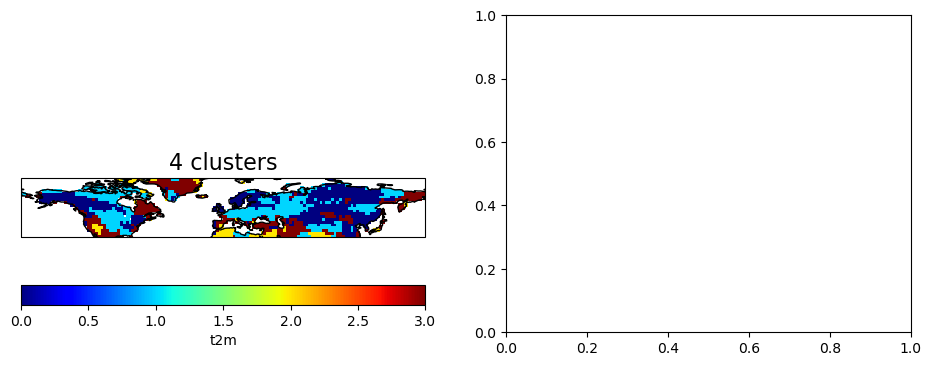

In [102]:
#plot
from matplotlib import cm

fig=plt.figure(figsize=(24,14))

ax=fig.add_subplot(3,4,1,projection=ccrs.PlateCarree())
glcluster_4cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
ax.set_title('4 clusters',fontsize=16)
ax.coastlines()

ax2=fig.add_subplot(3,4,2)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 4))
ax2.plot(trend_smoothed.dayofyear,normdat(cent4[0]), c=jet_2_colors[0],label='Heat trend')
ax2.plot(tempss_4cl_1.dayofyear,normdat(tempss_3cl_1),c=jet_2_colors[1],label='Temp trend')
ax2.plot(varss_4cl_1.dayofyear,-normdat(varss_3cl_1),c=jet_2_colors[2],label='Temp variability')
#ax2.plot(trend_smoothed.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
ax2.set_title('Cluster 1')
plt.legend()

ax2=fig.add_subplot(3,4,3)
jet = cm.get_cmap('jet')
#jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(trend_smoothed.dayofyear,normdat(cent3[1]), c=jet_2_colors[0],label='Heat trend')
ax2.plot(tempss_3cl_1.dayofyear,normdat(tempss_3cl_2),c=jet_2_colors[1],label='Temp trend')
ax2.plot(varss_3cl_1.dayofyear,-normdat(varss_3cl_2),c=jet_2_colors[2],label='Temp variability')
#ax2.plot(trend_smoothed.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
ax2.set_title('Cluster 2')
plt.legend()

ax2=fig.add_subplot(3,4,4)
jet = cm.get_cmap('jet')
#jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(trend_smoothed.dayofyear,normdat(cent3[2]), c=jet_2_colors[0],label='Heat trend')
ax2.plot(tempss_3cl_1.dayofyear,normdat(tempss_3cl_3),c=jet_2_colors[1],label='Temp trend')
ax2.plot(varss_3cl_3.dayofyear,-normdat(varss_3cl_3),c=jet_2_colors[2],label='Temp variability')
#ax2.plot(trend_smoothed.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
ax2.set_title('Cluster 3')
plt.legend()


# ax=fig.add_subplot(3,4,5,projection=ccrs.PlateCarree())
# glcluster_3cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
# ax.set_title('3 clusters',fontsize=16)
# ax.coastlines()

# ax2=fig.add_subplot(3,4,6)
# jet = cm.get_cmap('jet')
# jet_3_colors = jet(np.linspace(0, 1, 3))
# ax2.plot(trend_smoothed.dayofyear,cent3[0], c=jet_3_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,cent3[1],c=jet_3_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
# plt.legend()

# ax2=fig.add_subplot(3,4,7)
# jet = cm.get_cmap('jet')
# jet_2_colors = jet(np.linspace(0, 1, 2))
# ax2.plot(trend_smoothed.dayofyear,heatcl_3cl_1, c=jet_3_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,heatcl_3cl_2,c=jet_3_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,heatcl_3cl_3,c=jet_3_colors[2],label='cluster 2')
# plt.legend()

# ax2=fig.add_subplot(3,4,8)
# jet = cm.get_cmap('jet')
# jet_2_colors = jet(np.linspace(0, 1, 2))
# ax2.plot(trend_smoothed.dayofyear,heatss_3cl_1, c=jet_3_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,heatss_3cl_2,c=jet_3_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,heatss_3cl_3,c=jet_3_colors[2],label='cluster 2')
# plt.legend()

# ax=fig.add_subplot(3,4,9,projection=ccrs.PlateCarree())
# glcluster_6cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
# ax.set_title('6 clusters',fontsize=16)
# ax.coastlines()

# ax2=fig.add_subplot(3,4,10)
# jet_6_colors = jet(np.linspace(0, 1, 6))
# ax2.plot(trend_smoothed.dayofyear,cent6[0], c=jet_6_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,cent6[1], c=jet_6_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,cent6[2], c=jet_6_colors[2],label='cluster 2')
# ax2.plot(trend_smoothed.dayofyear,cent6[3], c=jet_6_colors[3],label='cluster 3')
# ax2.plot(trend_smoothed.dayofyear,cent6[4], c=jet_6_colors[4],label='cluster 4')
# ax2.plot(trend_smoothed.dayofyear,cent6[5], c=jet_6_colors[5],label='cluster 5')
# plt.legend()


# ax2=fig.add_subplot(3,4,11)
# jet = cm.get_cmap('jet')
# jet_2_colors = jet(np.linspace(0, 1, 2))
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_1, c=jet_6_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_2,c=jet_6_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_3,c=jet_6_colors[2],label='cluster 2')
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_4, c=jet_6_colors[3],label='cluster 3')
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_5, c=jet_6_colors[4],label='cluster 4')
# ax2.plot(trend_smoothed.dayofyear,heatcl_6cl_6, c=jet_6_colors[5],label='cluster 5')
# plt.legend()

# ax2=fig.add_subplot(3,4,12)
# jet = cm.get_cmap('jet')
# jet_2_colors = jet(np.linspace(0, 1, 2))
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_1, c=jet_6_colors[0],label='cluster 0')
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_2,c=jet_6_colors[1],label='cluster 1')
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_3,c=jet_6_colors[2],label='cluster 2')
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_4, c=jet_6_colors[3],label='cluster 3')
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_5, c=jet_6_colors[4],label='cluster 4')
# ax2.plot(trend_smoothed.dayofyear,heatss_6cl_6, c=jet_6_colors[5],label='cluster 5')
# plt.legend()

# # ax=fig.add_subplot(4,2,10,projection=ccrs.PlateCarree())
# # glcluster_10cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
# # ax.set_title('10 clusters',fontsize=16)
# # ax.coastlines()

# # ax2=fig.add_subplot(4,2,11)
# # jet_10_colors = jet(np.linspace(0, 1, 10))
# # ax2.plot(trend_smoothed.dayofyear,cent10[0], c=jet_10_colors[0],label='cluster 0')
# # ax2.plot(trend_smoothed.dayofyear,cent10[1], c=jet_10_colors[1],label='cluster 1')
# # ax2.plot(trend_smoothed.dayofyear,cent10[2], c=jet_10_colors[2],label='cluster 2')
# # ax2.plot(trend_smoothed.dayofyear,cent10[3], c=jet_10_colors[3],label='cluster 3')
# # ax2.plot(trend_smoothed.dayofyear,cent10[4], c=jet_10_colors[4],label='cluster 4')
# # ax2.plot(trend_smoothed.dayofyear,cent10[5], c=jet_10_colors[5],label='cluster 5')
# # ax2.plot(trend_smoothed.dayofyear,cent10[6], c=jet_10_colors[6],label='cluster 6')
# # ax2.plot(trend_smoothed.dayofyear,cent10[7], c=jet_10_colors[7],label='cluster 7')
# # ax2.plot(trend_smoothed.dayofyear,cent10[8], c=jet_10_colors[8],label='cluster 8')
# # ax2.plot(trend_smoothed.dayofyear,cent10[9], c=jet_10_colors[9],label='cluster 9')
# # plt.legend()

# # ax2=fig.add_subplot(4,3,12)
# # jet_6_colors = jet(np.linspace(0, 1, 6))
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_1, c=jet_2_colors[0],label='cluster 0')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_2,c=jet_2_colors[1],label='cluster 1')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_3,c=jet_3_colors[2],label='cluster 2')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_4, c=jet_6_colors[3],label='cluster 3')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_5, c=jet_6_colors[4],label='cluster 4')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_6, c=jet_6_colors[5],label='cluster 5')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_7, c=jet_10_colors[6],label='cluster 6')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_8, c=jet_10_colors[7],label='cluster 7')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_9, c=jet_10_colors[8],label='cluster 8')
# # ax2.plot(trend_smoothed.dayofyear,heatss_10cl_10, c=jet_10_colors[9],label='cluster 9')
# # plt.legend()
# plt.savefig('global_land_clusters_var_regrid.png')
plt.show()

In [133]:
from scipy.stats import pearsonr

# temp trends
cort1, pvalt1 = pearsonr(cent4[0], tempss_4cl_1.values)
cort2, pvalt2 = pearsonr(cent4[1], tempss_4cl_2.values)
cort3, pvalt3 = pearsonr(cent4[2], tempss_4cl_3.values)

corv1, pvalv1 = pearsonr(cent4[0], varss_4cl_1.values)
corv2, pvalv2 = pearsonr(cent4[1], varss_4cl_2.values)
corv3, pvalv3 = pearsonr(cent4[2], varss_4cl_3.values)

In [134]:
print(cort1,cort2,cort3)
print(pvalt1,pvalt2,pvalt3)
print(corv1,corv2,corv3)
print(pvalv1,pvalv2,pvalv3)

0.5116200388742742 0.7074091429359987 0.8605511467344523
9.723729742707075e-26 1.16530158331448e-56 2.1765108299870876e-108
-0.013209174211521294 0.48189925903116027 -0.9883403973250984
0.8014227091549345 1.272485160307797e-22 8.052344192696668e-299


### corr

In [144]:
#correlate
from scipy.stats import pearsonr
def pcor(x,y):
    return pearsonr(x, y)

tempstack=tempss.stack(z={'latitude','longitude'}).dropna(dim='dayofyear',how='all')

rzt=trend_stack.copy(deep=True).isel(dayofyear=0)
rzv=trend_stack.copy(deep=True).isel(dayofyear=0)


pzt=trend_stack.copy(deep=True).isel(dayofyear=0)
pzv=trend_stack.copy(deep=True).isel(dayofyear=0)

for i in range(len(trend_stack.z)):
    yheat=trend_stack[:,i].dropna(dim='dayofyear')
    xtemp=tempstack[:,i].dropna(dim='dayofyear')
    xvar=var_st_smoothed[:,i].dropna(dim='dayofyear')
    try:
        cor1,corp1 = pcor(xtemp.values,yheat.values)
        cor2,corp2 = pcor(xvar.values,yheat.values)
        rzt[i] = cor1
        pzt[i] = corp1
        rzv[i] = cor2
        pzv[i] = corp2
    
    except:
        rzt[i] = np.nan
        pzt[i] = np.nan
        rzv[i] = np.nan
        pzv[i] = np.nan

/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
#Plot
import matplotlib.ticker as mticker
lets=['a. ','b. ','c. ', 'd. ']
fig=plt.figure(figsize=(12,6))
cm=0
proj = ccrs.PlateCarree(central_longitude=cm)



ax=fig.add_subplot(211,projection=proj)
cor=rzt.unstack()
pval = pzt.unstack()

pval_sig = rotlon_180(xr.where(pval<0.05,1,np.nan))

# ax.set_xlim([-30,90])
rotlon_180(cor).plot(x='longitude',y='latitude',vmax=1,vmin=-1, ax=ax, cmap='RdBu_r',transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#sst_y1.sst.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[0]+'Heat trend-temperature trend correlation', fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()
#ax.set_xlim([-90,90]) 


ax=fig.add_subplot(212,projection=proj)
cor=rzv.unstack()
pval = pzv.unstack()

pval_sig = rotlon_180(xr.where(pval<0.05,1,np.nan))
# ax.set_xlim([-30,90])
m=cor.plot(x='longitude',y='latitude', ax=ax,vmax=1,vmin=-1,cmap='RdBu_r', transform=ccrs.PlateCarree(),add_colorbar=False)
ax.contourf(pval_sig.longitude.values,pval_sig.latitude.values,pval_sig.values.T,hatches='.', color='k', size=100, alpha=0., transform=ccrs.PlateCarree())
#t2msliced.t2m.mean(dim='time').plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(270,310,5), linestyle='--',colors='k')

ax.set_title('')
ax.set_title(lets[1]+'Heat trend-temperature variability correlation',fontsize=14, loc='left')
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30, 50, 70])
gl.xlabels_top = False
gl.ylabels_risst_mt = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
ax.coastlines()

#ax.set_xlim([-90,90])
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="Pearson's r",size=14)
cbl.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, bottom=0.2)



# plt.tight_layout()
plt.savefig('plots/Heattrend_temptrend-var_cor.png')
plt.show()


/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'color', 'size'
  result = super().contourf(*args, **kwargs)
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/rwhite/ladmasu/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.


## cluster on daily variability

In [185]:
temp_sdrol=temp_noleap.t2m.rolling(time=10,center=True).construct('window')
temp_sdgp=temp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
temp_doysd=temp_noleap.t2m.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
for i in range(len(temp_doygp)-1):
    if i!=59:
        curgp=temp_sdgp[i+1].copy().assign_coords(time=temp_doysd[i].time)
        temp_doysd[i,]=curgp.std(dim='window')
temp_doysd=temp_doysd.sel(doys=temp_doysd.doys!=60).mean(dim='time')

#temp_dvar=sd_doymn(temp_doytimes,10)

In [186]:
var_stack=temp_doysd.rename({'doys':'dayofyear'}).stack(z={'latitude','longitude'})
var_st_smoothed=clim_smoother(var_stack,90)
#smooth


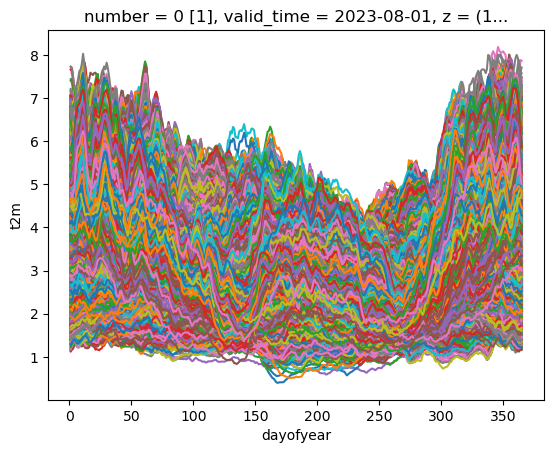

In [187]:
fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(len(trend_smoothed.z)):
    var_stack[:,i].plot(ax=ax)

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(len(trend_smoothed.z)):
    var_st_smoothed[:,i].plot(ax=ax)
plt.savefig('varsmoothed.png')

In [188]:
#remove mean for cluster
var_sm_dev=var_st_smoothed-var_st_smoothed.mean(dim='dayofyear')


In [ ]:
fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(len(trend_smoothed.z)):
    var_sm_dev[:,i].plot(ax=ax)
plt.savefig('mean_removed_var.png')

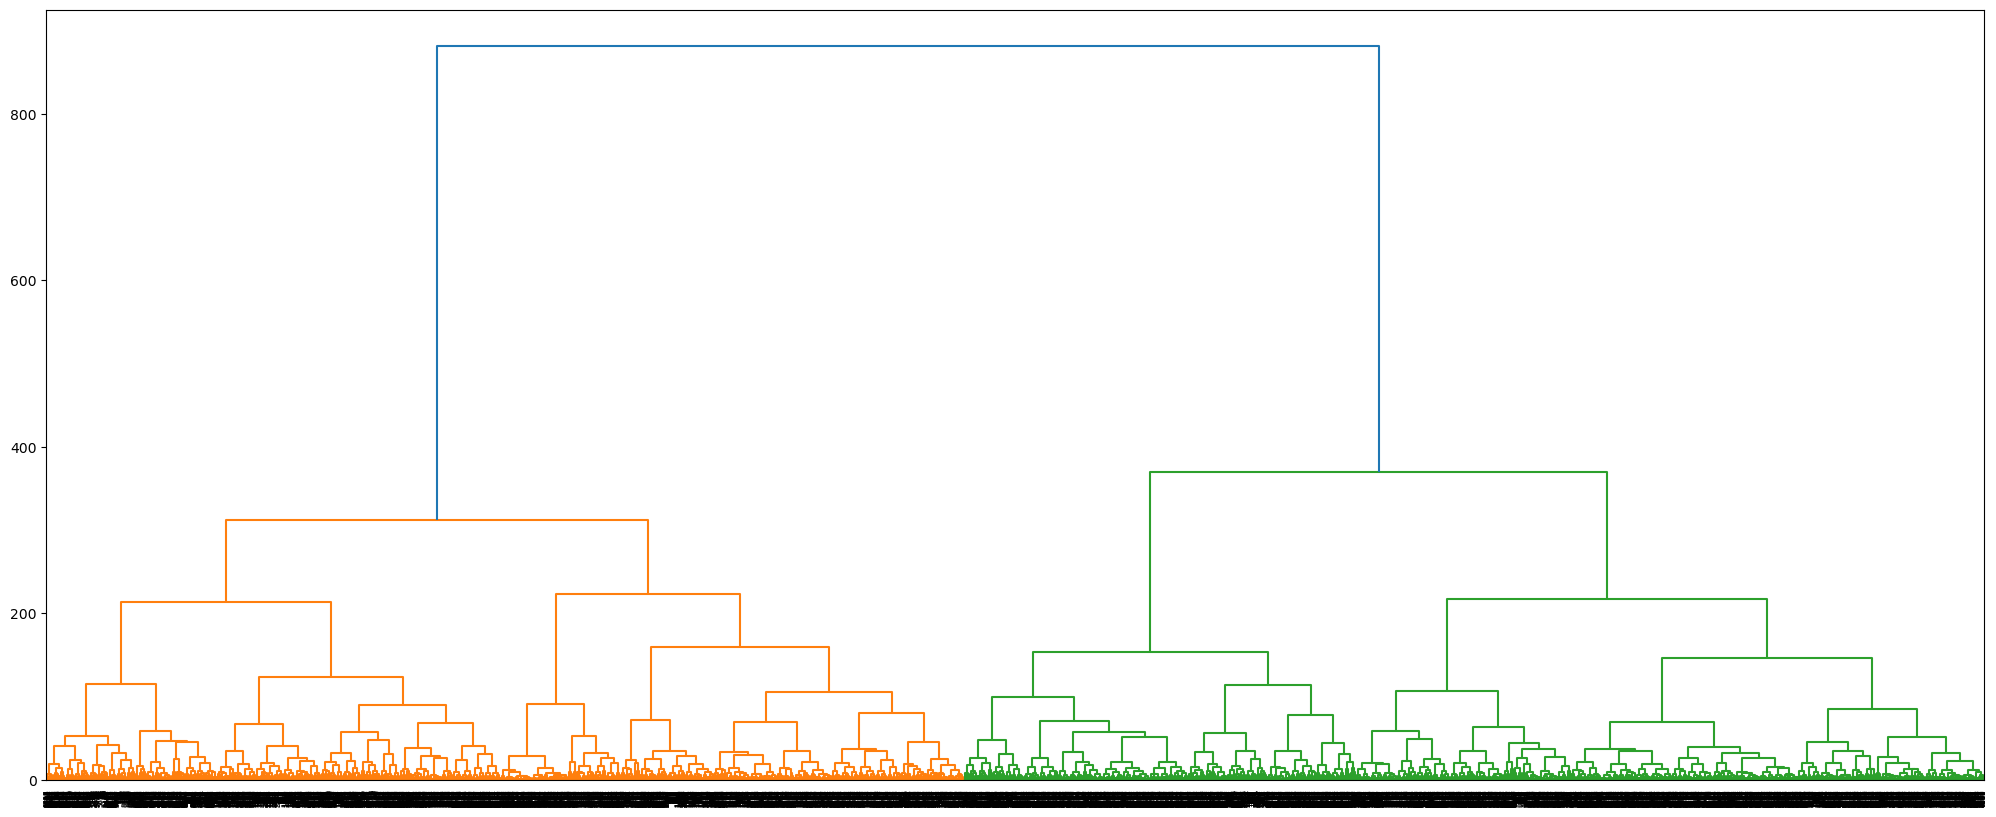

In [192]:
from scipy.cluster.hierarchy import dendrogram, linkage
var_sm_dev_na= var_sm_dev.dropna(dim='dayofyear',how='all').dropna(dim='z')


Z = linkage(var_sm_dev_na.T, 'ward') #
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [194]:
def kmns_glob(dat,n):
    
    data=dat.T
    num_cl=n
    whitened = whiten(data)
    centroids, mean_value =kmeans(whitened,num_cl)

    clusters, distances = vq(whitened, centroids)

    clusters_stack=xr.zeros_like(dat.isel(dayofyear=0).copy(deep=True))
    clusters_stack.values=clusters

    return clusters_stack,centroids

In [195]:
#clusters
var_dat=var_sm_dev.dropna(dim='z')

glcluster_2,cent2=kmns_glob(var_dat,2)
glcluster_3,cent3=kmns_glob(var_dat,3)
glcluster_6,cent6=kmns_glob(var_dat,6)
glcluster_10,cent10=kmns_glob(var_dat,10)

In [196]:
#nan vals
def unstack_nan(dat, dat_stack, dat_stackna):

    gl_un=dat_stack.isel(dayofyear=0).copy(deep=True)
    gl_nan=dat_stackna.isel(dayofyear=0).copy(deep=True)

    gl_nan.values=dat
    gl_un.loc[gl_un.z.isin(gl_nan.z)]=gl_nan
    
    out_stack=gl_un.unstack()
    
    out_stack=out_stack.transpose('latitude', 'longitude')
    return out_stack

In [197]:
glcluster_2cl=unstack_nan(glcluster_2,var_sm_dev, var_dat)
glcluster_3cl=unstack_nan(glcluster_3,var_sm_dev, var_dat)
glcluster_6cl=unstack_nan(glcluster_6,var_sm_dev, var_dat)
glcluster_10cl=unstack_nan(glcluster_10,var_sm_dev, var_dat)

In [198]:
heat_ss=xr.open_dataset('hw_doy_trends.nc')
heatss=clim_smoother(heat_ss.t2m.rename({'doys':'dayofyear'}),90)
heatss_2cl_1=heatss.where(glcluster_2cl==0).mean(dim=['latitude','longitude'])
heatss_2cl_2=heatss.where(glcluster_2cl==1).mean(dim=['latitude','longitude'])

heatss_3cl_1=heatss.where(glcluster_3cl==0).mean(dim=['latitude','longitude'])
heatss_3cl_2=heatss.where(glcluster_3cl==1).mean(dim=['latitude','longitude'])
heatss_3cl_3=heatss.where(glcluster_3cl==2).mean(dim=['latitude','longitude'])

heatss_6cl_1=heatss.where(glcluster_6cl==0).mean(dim=['latitude','longitude'])
heatss_6cl_2=heatss.where(glcluster_6cl==1).mean(dim=['latitude','longitude'])
heatss_6cl_3=heatss.where(glcluster_6cl==2).mean(dim=['latitude','longitude'])
heatss_6cl_4=heatss.where(glcluster_6cl==3).mean(dim=['latitude','longitude'])
heatss_6cl_5=heatss.where(glcluster_6cl==4).mean(dim=['latitude','longitude'])
heatss_6cl_6=heatss.where(glcluster_6cl==5).mean(dim=['latitude','longitude'])

# heatss_10cl_1=heatss.t2m.where(glcluster_10cl==0)
# heatss_10cl_2=heatss.t2m.where(glcluster_10cl==1)
# heatss_10cl_3=heatss.t2m.where(glcluster_10cl==2)
# heatss_10cl_4=heatss.t2m.where(glcluster_10cl==3)
# heatss_10cl_5=heatss.t2m.where(glcluster_10cl==4)
# heatss_10cl_6=heatss.t2m.where(glcluster_10cl==5)
# heatss_10cl_7=heatss.t2m.where(glcluster_10cl==6)
# heatss_10cl_8=heatss.t2m.where(glcluster_10cl==7)
# heatss_10cl_9=heatss.t2m.where(glcluster_10cl==8)
# heatss_10cl_10=heatss.t2m.where(glcluster_10cl==9)

In [213]:
heat_cl=heat_noleap.t2m.groupby('time.dayofyear').mean()
heatcl=clim_smoother(heat_cl,90)
heatcl_2cl_1=heatcl.where(glcluster_2cl==0).mean(dim=['latitude','longitude'])
heatcl_2cl_2=heatcl.where(glcluster_2cl==1).mean(dim=['latitude','longitude'])

heatcl_3cl_1=heatcl.where(glcluster_3cl==0).mean(dim=['latitude','longitude'])
heatcl_3cl_2=heatcl.where(glcluster_3cl==1).mean(dim=['latitude','longitude'])
heatcl_3cl_3=heatcl.where(glcluster_3cl==2).mean(dim=['latitude','longitude'])

heatcl_6cl_1=heatcl.where(glcluster_6cl==0).mean(dim=['latitude','longitude'])
heatcl_6cl_2=heatcl.where(glcluster_6cl==1).mean(dim=['latitude','longitude'])
heatcl_6cl_3=heatcl.where(glcluster_6cl==2).mean(dim=['latitude','longitude'])
heatcl_6cl_4=heatcl.where(glcluster_6cl==3).mean(dim=['latitude','longitude'])
heatcl_6cl_5=heatcl.where(glcluster_6cl==4).mean(dim=['latitude','longitude'])
heatcl_6cl_6=heatcl.where(glcluster_6cl==5).mean(dim=['latitude','longitude'])

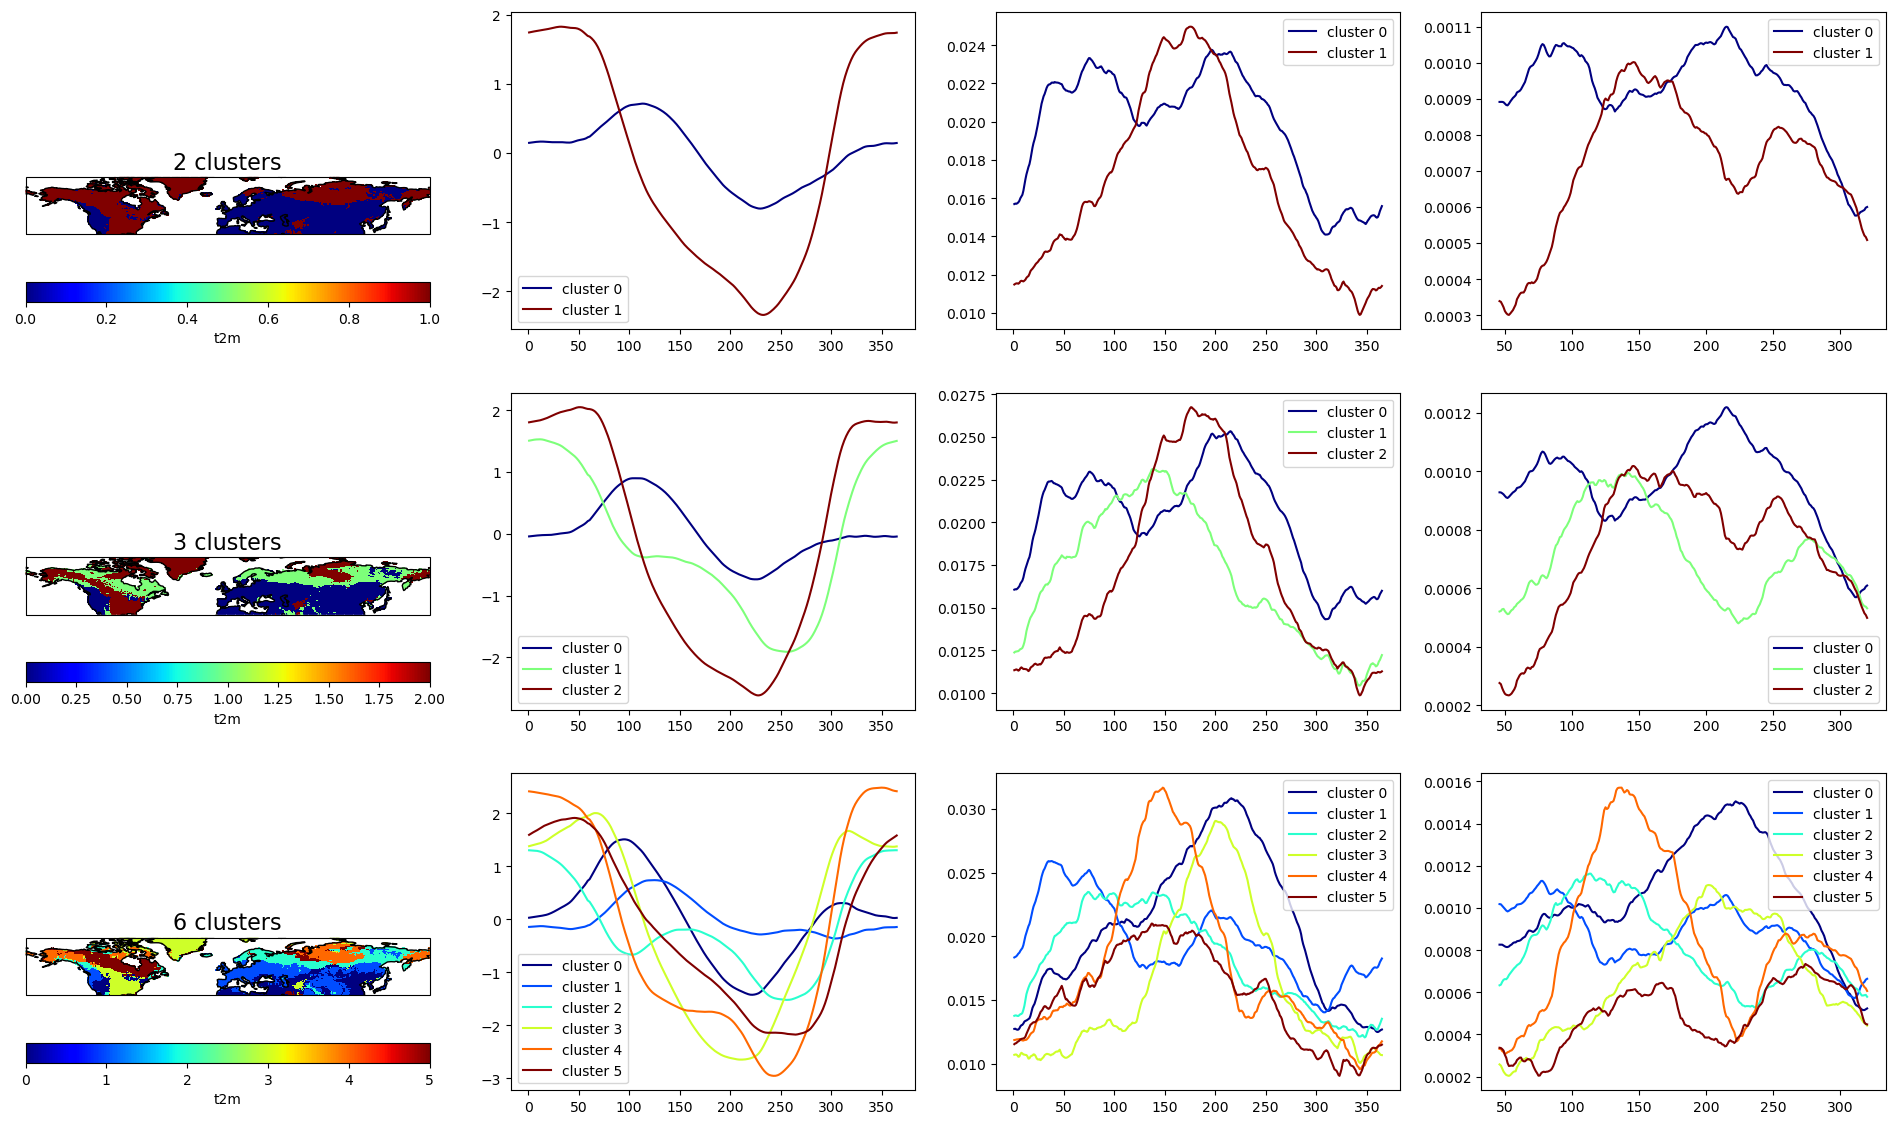

In [214]:
#plot
from matplotlib import cm

fig=plt.figure(figsize=(24,14))

ax=fig.add_subplot(3,4,1,projection=ccrs.PlateCarree())
glcluster_2cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
ax.set_title('2 clusters',fontsize=16)
ax.coastlines()

ax2=fig.add_subplot(3,4,2)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,cent2[0], c=jet_2_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,cent2[1],c=jet_2_colors[1],label='cluster 1')
#ax2.plot(var_dat.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
plt.legend()

ax2=fig.add_subplot(3,4,3)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatcl_2cl_1, c=jet_2_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatcl_2cl_2,c=jet_2_colors[1],label='cluster 1')
#ax2.plot(var_dat.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
plt.legend()

ax2=fig.add_subplot(3,4,4)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatss_2cl_1, c=jet_2_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatss_2cl_2,c=jet_2_colors[1],label='cluster 1')
#ax2.plot(var_dat.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
plt.legend()


ax=fig.add_subplot(3,4,5,projection=ccrs.PlateCarree())
glcluster_3cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
ax.set_title('3 clusters',fontsize=16)
ax.coastlines()

ax2=fig.add_subplot(3,4,6)
jet = cm.get_cmap('jet')
jet_3_colors = jet(np.linspace(0, 1, 3))
ax2.plot(var_dat.dayofyear,cent3[0], c=jet_3_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,cent3[1],c=jet_3_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,cent3[2],c=jet_3_colors[2],label='cluster 2')
plt.legend()

ax2=fig.add_subplot(3,4,7)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatcl_3cl_1, c=jet_3_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatcl_3cl_2,c=jet_3_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,heatcl_3cl_3,c=jet_3_colors[2],label='cluster 2')
plt.legend()

ax2=fig.add_subplot(3,4,8)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatss_3cl_1, c=jet_3_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatss_3cl_2,c=jet_3_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,heatss_3cl_3,c=jet_3_colors[2],label='cluster 2')
plt.legend()

ax=fig.add_subplot(3,4,9,projection=ccrs.PlateCarree())
glcluster_6cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
ax.set_title('6 clusters',fontsize=16)
ax.coastlines()

ax2=fig.add_subplot(3,4,10)
jet_6_colors = jet(np.linspace(0, 1, 6))
ax2.plot(var_dat.dayofyear,cent6[0], c=jet_6_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,cent6[1], c=jet_6_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,cent6[2], c=jet_6_colors[2],label='cluster 2')
ax2.plot(var_dat.dayofyear,cent6[3], c=jet_6_colors[3],label='cluster 3')
ax2.plot(var_dat.dayofyear,cent6[4], c=jet_6_colors[4],label='cluster 4')
ax2.plot(var_dat.dayofyear,cent6[5], c=jet_6_colors[5],label='cluster 5')
plt.legend()


ax2=fig.add_subplot(3,4,11)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatcl_6cl_1, c=jet_6_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatcl_6cl_2,c=jet_6_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,heatcl_6cl_3,c=jet_6_colors[2],label='cluster 2')
ax2.plot(var_dat.dayofyear,heatcl_6cl_4, c=jet_6_colors[3],label='cluster 3')
ax2.plot(var_dat.dayofyear,heatcl_6cl_5, c=jet_6_colors[4],label='cluster 4')
ax2.plot(var_dat.dayofyear,heatcl_6cl_6, c=jet_6_colors[5],label='cluster 5')
plt.legend()

ax2=fig.add_subplot(3,4,12)
jet = cm.get_cmap('jet')
jet_2_colors = jet(np.linspace(0, 1, 2))
ax2.plot(var_dat.dayofyear,heatss_6cl_1, c=jet_6_colors[0],label='cluster 0')
ax2.plot(var_dat.dayofyear,heatss_6cl_2,c=jet_6_colors[1],label='cluster 1')
ax2.plot(var_dat.dayofyear,heatss_6cl_3,c=jet_6_colors[2],label='cluster 2')
ax2.plot(var_dat.dayofyear,heatss_6cl_4, c=jet_6_colors[3],label='cluster 3')
ax2.plot(var_dat.dayofyear,heatss_6cl_5, c=jet_6_colors[4],label='cluster 4')
ax2.plot(var_dat.dayofyear,heatss_6cl_6, c=jet_6_colors[5],label='cluster 5')
plt.legend()

# ax=fig.add_subplot(4,2,10,projection=ccrs.PlateCarree())
# glcluster_10cl.plot(ax=ax,cmap='jet',transform=ccrs.PlateCarree(),cbar_kwargs={'orientation':'horizontal'})
# ax.set_title('10 clusters',fontsize=16)
# ax.coastlines()

# ax2=fig.add_subplot(4,2,11)
# jet_10_colors = jet(np.linspace(0, 1, 10))
# ax2.plot(var_dat.dayofyear,cent10[0], c=jet_10_colors[0],label='cluster 0')
# ax2.plot(var_dat.dayofyear,cent10[1], c=jet_10_colors[1],label='cluster 1')
# ax2.plot(var_dat.dayofyear,cent10[2], c=jet_10_colors[2],label='cluster 2')
# ax2.plot(var_dat.dayofyear,cent10[3], c=jet_10_colors[3],label='cluster 3')
# ax2.plot(var_dat.dayofyear,cent10[4], c=jet_10_colors[4],label='cluster 4')
# ax2.plot(var_dat.dayofyear,cent10[5], c=jet_10_colors[5],label='cluster 5')
# ax2.plot(var_dat.dayofyear,cent10[6], c=jet_10_colors[6],label='cluster 6')
# ax2.plot(var_dat.dayofyear,cent10[7], c=jet_10_colors[7],label='cluster 7')
# ax2.plot(var_dat.dayofyear,cent10[8], c=jet_10_colors[8],label='cluster 8')
# ax2.plot(var_dat.dayofyear,cent10[9], c=jet_10_colors[9],label='cluster 9')
# plt.legend()

# ax2=fig.add_subplot(4,3,12)
# jet_6_colors = jet(np.linspace(0, 1, 6))
# ax2.plot(var_dat.dayofyear,heatss_10cl_1, c=jet_2_colors[0],label='cluster 0')
# ax2.plot(var_dat.dayofyear,heatss_10cl_2,c=jet_2_colors[1],label='cluster 1')
# ax2.plot(var_dat.dayofyear,heatss_10cl_3,c=jet_3_colors[2],label='cluster 2')
# ax2.plot(var_dat.dayofyear,heatss_10cl_4, c=jet_6_colors[3],label='cluster 3')
# ax2.plot(var_dat.dayofyear,heatss_10cl_5, c=jet_6_colors[4],label='cluster 4')
# ax2.plot(var_dat.dayofyear,heatss_10cl_6, c=jet_6_colors[5],label='cluster 5')
# ax2.plot(var_dat.dayofyear,heatss_10cl_7, c=jet_10_colors[6],label='cluster 6')
# ax2.plot(var_dat.dayofyear,heatss_10cl_8, c=jet_10_colors[7],label='cluster 7')
# ax2.plot(var_dat.dayofyear,heatss_10cl_9, c=jet_10_colors[8],label='cluster 8')
# ax2.plot(var_dat.dayofyear,heatss_10cl_10, c=jet_10_colors[9],label='cluster 9')
# plt.legend()
plt.savefig('global_land_clusters_var.png')
plt.show()

## Variability trend

In [94]:
temp_sdrol=temp_noleap.t2m.rolling(time=10,center=True).construct('window')
temp_sdgp=temp_sdrol.groupby('time.dayofyear')
#heat_doygp=heat_noleap.t2m.groupby('time.dayofyear')
temp_doysd=temp_noleap.t2m.groupby('time.year').mean().expand_dims({'doys':np.arange(1,366)}).copy().rename({'year':'time'})
for i in range(len(temp_doygp)-1):
    if i!=59:
        curgp=temp_sdgp[i+1].copy().assign_coords(time=temp_doysd[i].time)
        temp_doysd[i,]=curgp.std(dim='window')
#temp_doysd=temp_doysd.sel(doys=temp_doysd.doys!=60).mean(dim='time')

#temp_dvar=sd_doymn(temp_doytimes,10)

In [95]:
var_doytimes_ds=temp_doysd.to_dataset(name='t2m')
var_doy_timesrech=var_doytimes_ds.chunk({ 'longitude': 11,'doys':61})

In [97]:
#chunk and slope
from scipy.stats import linregress
time=heat_doy_timesrech.time.values.astype('datetime64[D]').astype(int)
def linregress_wrapper(y, time):
    slope, intercept, r, p, std_err = linregress(time, y)
    return slope, p

slope, pval = xr.apply_ufunc(
        linregress_wrapper,
        var_doy_timesrech.t2m,  # your variable (time on first axis)
        time,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float]
    )
#mann kendall version
# slope, pval = xr.apply_ufunc(
#         manntrend,
#         var_doy_timesrech.t2m,  # your variable (time on first axis)
#         input_core_dims=[['year']],
#         output_core_dims=[[], []],
#         vectorize=True,
#         dask='parallelized',
#         output_dtypes=[float, float]
#     )

In [98]:
ss=slope.compute()#.mean(dim=['latitude','longitude'])
#ss1=sss..compute()#.plot()

In [99]:
ss.to_dataset(name='t2m').to_netcdf('var_doy_trends_regrid.nc')

## other